In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xgcm
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)

w = cluster.start_workers(10)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.14:47628 Dashboard: http://10.148.1.14:8787/status,Cluster Workers: 20 Cores: 80 Memory: 1000.00 GB


___________

# 1. randomly choose a number (n = 20) of mooring array in the OSMOSIS domain

In [75]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'
out_dir_mooring = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'

# random subsampling number
size = 20

# lat & lon of the real OSMOSIS moorings
lat_real_mooring = xr.DataArray([ 48.6875,  48.6940,  48.7480,  48.7000,  48.7485,  48.6803,  48.6290,  48.6780,  48.6290], dims='mooring')
lon_real_mooring = xr.DataArray([-16.1875, -16.1740, -16.0945, -16.2060, -16.2762, -16.1740, -16.0990, -16.2050, -16.2775], dims='mooring')

In [84]:
# lat_range = np.arange(47.7,49.7,0.1) # large range
# lon_range = np.arange(-17.2,-15.2,0.1) # large range

lat_range = np.arange(48.2,49.2,0.1)
lon_range = np.arange(-16.7,-15.7,0.1)


lat_C = np.random.choice(lat_range,size=size,replace=True)
lon_C = np.random.choice(lon_range,size=size,replace=True)

In [85]:
# C, N-I,N-O, W-I, W-O, E-I, E-O, S-I, S-O
inner = 0.025
outer = 0.075

lat_mooring = xr.DataArray([lat_C, lat_C+inner, lat_C+outer, lat_C,       lat_C,       lat_C,       lat_C,       lat_C-inner, lat_C-outer], dims=['mooring_array','location'])
lon_mooring = xr.DataArray([lon_C, lon_C,       lon_C,       lon_C-inner, lon_C-outer, lon_C+inner, lon_C+outer, lon_C,       lon_C      ], dims=['mooring_array','location'])

print(lat_mooring.isel(location=1))
print(lon_mooring.isel(location=1))

<xarray.DataArray (mooring_array: 9)>
array([49.1  , 49.125, 49.175, 49.1  , 49.1  , 49.1  , 49.1  , 49.075, 49.025])
Dimensions without coordinates: mooring_array
<xarray.DataArray (mooring_array: 9)>
array([-16.7  , -16.7  , -16.7  , -16.725, -16.775, -16.675, -16.625, -16.7  ,
       -16.7  ])
Dimensions without coordinates: mooring_array


# 2. horizontal velocity (needs interpolation using xgcm.grid)

In [93]:
grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_store/Grid.nc', decode_coords=True)

ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')

ds = xr.merge([ds_U,ds_V,grid])
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat_g    (lat_g) float32 47.39811 47.41132 47.424526 47.43773 47.45093 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon_g    (lon_g) float32 -18.041666 -18.020834 -18.0 -17.979166 ...
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    dxC      (lat, lon_g) float32 ...
    dyC      (lat_g, lon) float32 ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
Data variables:


In [94]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'}})
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon (177) --> left
  * left     lon_g (177) --> center
Y Axis (periodic):
  * center   lat (201) --> left
  * left     lat_g (201) --> center


In [95]:
ds_U_ji = gridx.interp(ds['U'],axis='Y') 
ds_U_ji = np.real(ds_U_ji).rename('U')
ds_U_ji = ds_U_ji.to_dataset()
print(ds_U_ji)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
Data variables:
    U        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(9415, 1, 200, 177)>


In [96]:
ds_V_ji = gridx.interp(ds_V['V'],axis='X') 
ds_V_ji = np.real(ds_V_ji).rename('V')
ds_V_ji = ds_V_ji.to_dataset()
print(ds_V_ji)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
Data variables:
    V        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(9415, 1, 201, 176)>


In [97]:
U_mooring_site = ds_U_ji.sel(lat=lat_mooring, lon=lon_mooring, method='backfill')
print(U_mooring_site)

<xarray.Dataset>
Dimensions:  (depth: 52, location: 20, mooring_array: 9, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring_array, location) float64 48.31 49.11 48.31 49.11 48.9 ...
    lon      (mooring_array, location) float64 -16.49 -16.7 -16.7 -16.39 ...
Dimensions without coordinates: location, mooring_array
Data variables:
    U        (time, depth, mooring_array, location) float32 dask.array<shape=(9415, 52, 9, 20), chunksize=(9415, 1, 9, 20)>


In [98]:
V_mooring_site = ds_V_ji.sel(lat=lat_mooring, lon=lon_mooring, method='backfill')
print(V_mooring_site)

<xarray.Dataset>
Dimensions:  (depth: 52, location: 20, mooring_array: 9, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring_array, location) float64 48.31 49.11 48.31 49.11 48.9 ...
    lon      (mooring_array, location) float64 -16.49 -16.7 -16.7 -16.39 ...
Dimensions without coordinates: location, mooring_array
Data variables:
    V        (time, depth, mooring_array, location) float32 dask.array<shape=(9415, 52, 9, 20), chunksize=(9415, 1, 9, 20)>


In [99]:
file_out = out_dir_mooring+'U_mooring_random.nc'
U_mooring_site.to_netcdf(file_out, mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [105]:
file_out = out_dir_mooring+'V_mooring_random.nc'
V_mooring_site.to_netcdf(file_out, mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [100]:
ds = xr.open_mfdataset(out_dir_mooring+'U_mooring.nc')
ds

<xarray.Dataset>
Dimensions:  (depth: 52, location: 20, mooring_array: 9, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring_array, location) float32 dask.array<shape=(9, 20), chunksize=(9, 20)>
    lon      (mooring_array, location) float32 dask.array<shape=(9, 20), chunksize=(9, 20)>
Dimensions without coordinates: location, mooring_array
Data variables:
    U        (time, depth, mooring_array, location) float32 dask.array<shape=(9415, 52, 9, 20), chunksize=(9415, 52, 9, 20)>

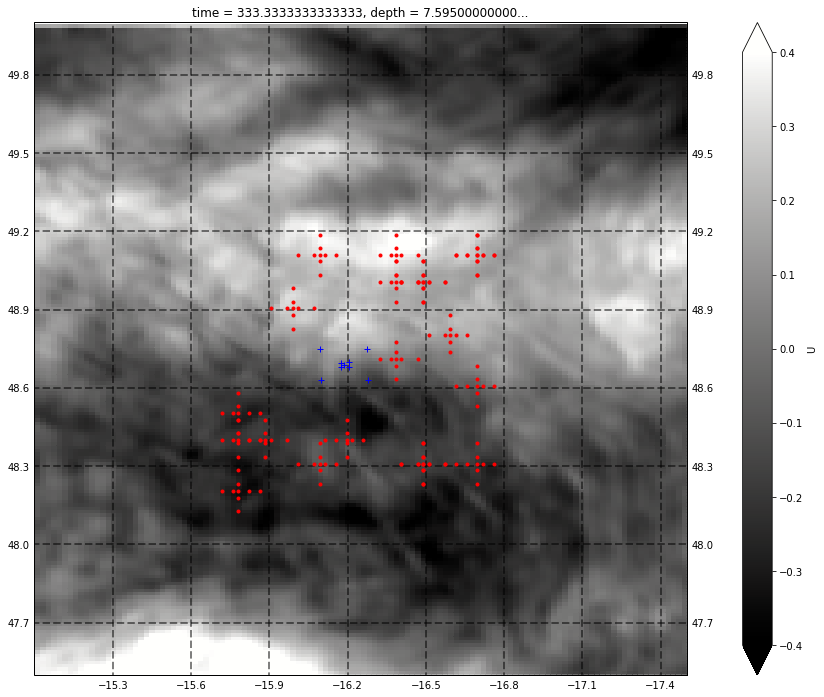

In [109]:
tem = ds_U_ji['U'].isel(depth=5,time=8000) 

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tem.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cm.gray, vmin=-0.4, vmax=0.4)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

ax.plot(lon_real_mooring,lat_real_mooring, 'b+')
#ax.plot(U_mooring_site.lon,U_mooring_site.lat, 'r+')

ax.plot(ds.lon,ds.lat, 'r.')


ax.set_xlim([-15.,-17.5]);
ax.set_ylim([47.5,50.]);

___________
# 3. Temperature, salinity and vertical velocity (at cell center)

In [106]:
ds_T = xr.open_zarr(out_dir_zarr+'Theta_total_rechunk.zarr')
ds_S = xr.open_zarr(out_dir_zarr+'Salt_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
print(ds_T)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
Dimensions without coordinates: time
Data variables:
    Theta    (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(9415, 1, 201, 177)>


In [107]:
T_mooring_site = ds_T.sel(lat=lat_mooring, lon=lon_mooring, method='backfill')
S_mooring_site = ds_S.sel(lat=lat_mooring, lon=lon_mooring, method='backfill')
W_mooring_site = ds_W.sel(lat=lat_mooring, lon=lon_mooring, method='backfill')

print(T_mooring_site)

<xarray.Dataset>
Dimensions:  (depth: 52, location: 20, mooring_array: 9, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring_array, location) float64 48.31 49.11 48.31 49.11 48.9 ...
    lon      (mooring_array, location) float64 -16.49 -16.7 -16.7 -16.39 ...
Dimensions without coordinates: location, mooring_array, time
Data variables:
    Theta    (time, depth, mooring_array, location) float32 dask.array<shape=(9415, 52, 9, 20), chunksize=(9415, 1, 9, 20)>


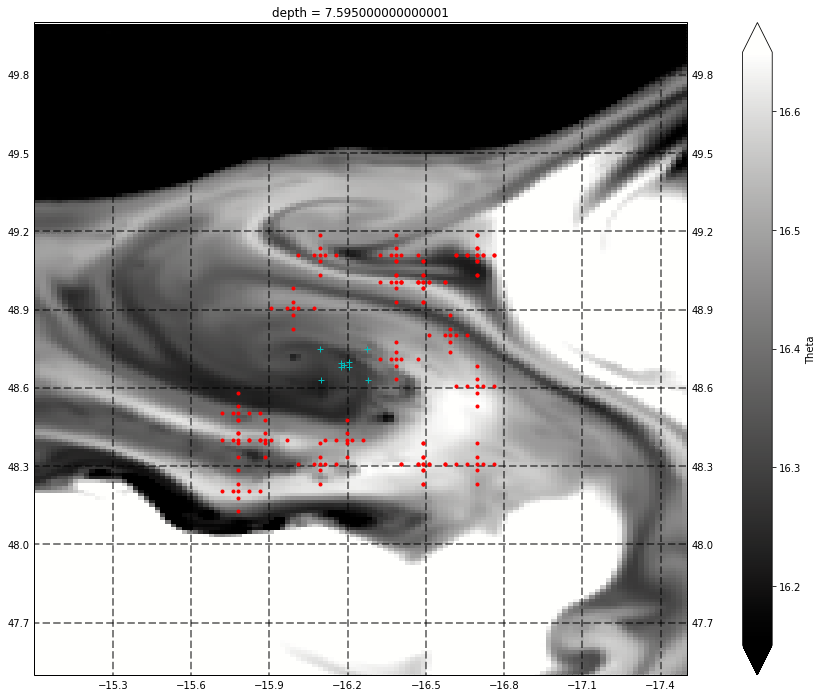

In [108]:
tem = ds_T['Theta'].isel(depth=5,time=8000) 

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tem.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cm.gray, vmin= 16.15, vmax=16.65)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

ax.plot(lon_real_mooring,lat_real_mooring, 'c+')
#ax.plot(T_mooring_site.lon.isel(array=10),T_mooring_site.lat.isel(array=10), 'r+')
ax.plot(T_mooring_site.lon,T_mooring_site.lat, 'r.')

ax.set_xlim([-15.,-17.5]);
ax.set_ylim([47.5,50.]);

In [110]:
file_out = out_dir_mooring+'T_mooring_random.nc'
T_mooring_site.to_netcdf(file_out, mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [111]:
file_out = out_dir_mooring+'S_mooring_random.nc'
S_mooring_site.to_netcdf(file_out, mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [112]:
file_out = out_dir_mooring+'W_mooring_random.nc'
W_mooring_site.to_netcdf(file_out, mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [114]:
cluster.scheduler.close()

<Future finished result=None>